In [1]:
# Pytorch libraries
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torchvision
from torchsummary import summary

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
from timeit import default_timer as timer

# Custom libraries
from pytorch_generator import PytorchDataGenerator, PytorchDataGenerator_Test

In [2]:
#### Set the CNN parameters
num_epoch = 20
batch_size = 6
framework = "torch"
im_size = 224
num_im = 1000
model_type = "simple"
predict = True

In [5]:
# Set up directories
root_path = "./"
data_dir = os.path.join(root_path, "dogs-vs-cats/train")
log_dir = os.path.join(
    root_path,
    "logs",
    framework,
    model_type,
    "logs",
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)
# if predict:
#     ckpt_name = "20200816-164919.pt"
#     ckpt_dir = os.path.join(
#         root_path, "logs", framework, model_type, "ckpts", ckpt_name
#     )
# else:
ckpts_path = os.path.join(
    root_path,
    "logs",
    framework,
    "ckpts")
if not os.path.exists(ckpts_path):
    os.mkdir(ckpts_path)
         
ckpt_dir = os.path.join(
    ckpts_path,
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)


In [6]:
# Get image names
train_dir = os.path.join(root_path, "dogs-vs-cats/train")
test_dir = os.path.join(root_path, "dogs-vs-cats/test")

train_dogs = [
    f"{train_dir}/{i}" for i in os.listdir(train_dir) if "dog" in i
]  # get dog images
train_cats = [
    f"{train_dir}/{i}" for i in os.listdir(train_dir) if "cat" in i
]  # get cat images
test_imgs = [f"{test_dir}/{i}" for i in os.listdir(test_dir)]

if num_im:  # Combine dog and cat images, then shuffle them
    all_imgs = (
        train_dogs[: np.int(num_im / 2)] + train_cats[: np.int(num_im / 2)]
    )  # train_dogs + train_cats # #, slice the dataset and use 2000 in each class
else:
    all_imgs = train_dogs + train_cats
random.seed(0)
random.shuffle(all_imgs)  # shuffle it randomly
random.shuffle(test_imgs)  # shuffle it randomly

train_imgs = all_imgs[: np.int(0.85 * len(all_imgs))]
val_imgs = all_imgs[np.int(0.85 * len(all_imgs)) :]

In [7]:
# Setup generators
train_set = PytorchDataGenerator(
    train_imgs, model_type=model_type, validation=False, im_size=im_size
)
train_gen = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=8
)

val_set = PytorchDataGenerator(
    val_imgs, model_type=model_type, validation=True, im_size=im_size
)
val_gen = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=8
)

test_set = PytorchDataGenerator_Test(test_imgs, model_type=model_type, im_size=im_size)
test_gen = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=8
)

num ims: 850
num ims: 150
num ims: 12500


/home/kokubuntu/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
# torch.set_num_threads(8)
# print(torch.get_num_threads())
# Set up model


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(18432, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 18432)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [9]:
learning_rate = 1e-3
model = CNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Setup tensorboard
file_writer = SummaryWriter(log_dir=log_dir + "/metrics")
best_val_acc = 0  # for model check pointing
# Epoch loop
for epoch in range(1, num_epoch + 1):
    start_time = timer()
    # Reset metrics
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0.0
    val_correct = 0.0

    # Training loop
    model.train()
    for inputs, targets in train_gen:
        # use GPU if available
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs = inputs.float()
        targets = targets.view(-1, 1).float()

        # Training steps
        optimizer.zero_grad()  # clear gradients
        output = model(inputs)  # forward pass: predict outputs for each image
        loss = loss_fn(output, targets)  # calculate loss
        loss.backward()  # backward pass: compute gradient of the loss wrt model parameters
        optimizer.step()  # update parameters
        train_loss += loss.item() * inputs.size(0)  # update training loss
        train_correct += (
            ((output > 0.5) == targets).float().sum()
        )  # update training accuracy

    # Validation loop
    model.eval()
    for inputs, targets in val_gen:
        # use GPU if available
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs = inputs.float()
        targets = targets.view(-1, 1).float()

        # Validation steps
        with torch.no_grad():  # not calculating gradients every step
            output = model(inputs)  # forward pass: predict outputs for each image
            loss = loss_fn(output, targets)  # calculate loss
            val_loss += loss.item() * inputs.size(0)  # update validation loss
            val_correct += (
                ((output > 0.5) == targets).float().sum()
            )  # update validation accuracy

    # calculate average losses and accuracy
    train_loss = train_loss / len(train_gen.sampler)
    val_loss = val_loss / len(val_gen.sampler)
    train_acc = train_correct / len(train_gen.sampler)
    val_acc = val_correct / len(val_gen.sampler)
    end_time = timer()  # get time taken for epoch

    # Display metrics at the end of each epoch.
    print(
        f"Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {val_loss} \tTraining Accuracy: {train_acc} \tValidation Accuracy: {val_acc} \t Time taken: {end_time - start_time}"
    )

    # Log metrics to tensorboard
    file_writer.add_scalar("Loss/train", train_loss, epoch)
    file_writer.add_scalar("Loss/validation", val_loss, epoch)
    file_writer.add_scalar("Accuracy/train", train_acc, epoch)
    file_writer.add_scalar("Accuracy/validation", val_acc, epoch)
    file_writer.add_scalar("epoch_time", end_time - start_time, epoch)

    # checkpoint if improved
    if val_acc > best_val_acc:
        state_dict = model.state_dict()
        torch.save(state_dict, ckpt_dir + ".pt")
        best_val_acc = val_acc

/home/kokubuntu/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 	Training Loss: 0.005945255862667075 	Validation Loss: 0.0 	Training Accuracy: 0.99294114112854 	Validation Accuracy: 1.0 	 Time taken: 5.12117969800056
Epoch: 2 	Training Loss: 0.0 	Validation Loss: 0.0 	Training Accuracy: 0.9999999403953552 	Validation Accuracy: 1.0 	 Time taken: 4.951028373000554
Epoch: 3 	Training Loss: 0.0 	Validation Loss: 0.0 	Training Accuracy: 0.9999999403953552 	Validation Accuracy: 1.0 	 Time taken: 4.772367176999978
Epoch: 4 	Training Loss: 0.0 	Validation Loss: 0.0 	Training Accuracy: 0.9999999403953552 	Validation Accuracy: 1.0 	 Time taken: 4.845477532999212
Epoch: 5 	Training Loss: 0.0 	Validation Loss: 0.0 	Training Accuracy: 0.9999999403953552 	Validation Accuracy: 1.0 	 Time taken: 4.714536311000302
Epoch: 6 	Training Loss: 0.0 	Validation Loss: 0.0 	Training Accuracy: 0.9999999403953552 	Validation Accuracy: 1.0 	 Time taken: 4.8146010439995734
Epoch: 7 	Training Loss: 0.0 	Validation Loss: 0.0 	Training Accuracy: 0.9999999403953552 	Valida

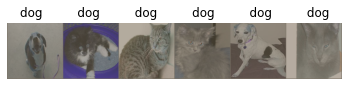

In [18]:
model.load_state_dict(torch.load(ckpt_dir + ".pt"))

for inputs, targets in test_gen:
    # use GPU if available
    inputs = inputs.to(device)
    inputs = inputs.float()
    outputs = model(inputs)
    break

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.savefig(f"./{framework}_{model_type}_test_imgs.png", dpi=300)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out.cpu(), title="         ".join(["cat" if i < 0 else "dog" for i in outputs.cpu()]))
